In [1]:
# 1. Import necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import numpy as np
import seaborn as sns
import shap




# 2. Load your dataset
df = pd.read_csv('dataset.csv')
df


,stay_id,subject_id,weaning_success,age,sex,bmi,charlson_comorbidity_index,chronic_pulmonary_disease,congestive_heart_failure,dementia,...,min_platelet,min_ph,min_pao2,max_paco2,min_baseexcess,lowest_tidal_volume,lowest_oi,highest_fio2,min_gcs,max_peep
0,37510196,10001884,0,77,F,26.370238,5,1,0,0,...,171.0,7.22,72.0,94.0,5.0,408.0,NaN,100.0,15.0,5.2
1,39060235,10002013,1,57,F,40.589882,7,1,1,0,...,252.0,7.27,90.0,56.0,-4.0,568.0,180.000000,100.0,15.0,5.0
2,35479615,10002428,1,81,F,NaN,6,0,1,0,...,164.0,NaN,NaN,NaN,NaN,256.0,NaN,30.0,15.0,5.0
3,31831386,10002760,1,56,M,27.728269,3,1,1,0,...,139.0,7.24,95.0,57.0,-5.0,375.0,128.750000,100.0,15.0,10.0
4,32128372,10003400,1,75,F,33.352230,8,0,1,0,...,74.0,NaN,NaN,NaN,NaN,380.0,NaN,30.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16515,32641669,19998330,1,72,F,NaN,8,1,1,0,...,377.0,7.28,78.0,92.0,10.0,338.0,195.000000,40.0,15.0,8.5
16516,31417783,19998330,1,72,F,NaN,8,1,1,0,...,406.0,7.37,73.0,63.0,7.0,316.0,212.500000,80.0,15.0,5.0
16517,30988867,19998843,1,45,M,27.777778,0,0,0,0,...,87.0,7.42,377.0,46.0,5.0,401.0,1077.142857,100.0,3.0,5.0
16518,32336619,19999442,1,43,M,28.859835,4,1,0,0,...,121.0,7.41,159.0,37.0,0.0,518.0,397.500000,50.0,10.0,5.0


In [2]:
# 3. Define features (X) and target (y)
target = 'weaning_success'
X = df.drop(columns=['stay_id', 'subject_id', target])  # Drop IDs and target
y = df[target]  # This is the label (0 = failure, 1 = success)

# 4.  Convert 'sex' column to numeric: Male = 1, Female = 0
X['sex_male'] = X['sex'].map({'M': 1, 'F': 0})

#Drop the original 'sex' column
X.drop(columns=['sex'], inplace=True)




In [10]:
# Count the number of 0s and 1s in the target variable
print("Target class distribution (weaning_success):")
print(y.value_counts())

# Optional: print as percentages
print("\nPercentage distribution:")
print(y.value_counts(normalize=True) * 100)

Target class distribution (weaning_success):
weaning_success
1    13775
0     2745
Name: count, dtype: int64

Percentage distribution:
weaning_success
1    83.383777
0    16.616223
Name: proportion, dtype: float64


In [3]:
X

,age,bmi,charlson_comorbidity_index,chronic_pulmonary_disease,congestive_heart_failure,dementia,severe_liver_disease,renal_disease,rheumatic_disease,diabetes,...,min_ph,min_pao2,max_paco2,min_baseexcess,lowest_tidal_volume,lowest_oi,highest_fio2,min_gcs,max_peep,sex_male
0,77,26.370238,5,1,0,0,0,0,0,0,...,7.22,72.0,94.0,5.0,408.0,NaN,100.0,15.0,5.2,0
1,57,40.589882,7,1,1,0,0,0,0,1,...,7.27,90.0,56.0,-4.0,568.0,180.000000,100.0,15.0,5.0,0
2,81,NaN,6,0,1,0,0,0,1,0,...,NaN,NaN,NaN,NaN,256.0,NaN,30.0,15.0,5.0,0
3,56,27.728269,3,1,1,0,0,0,0,0,...,7.24,95.0,57.0,-5.0,375.0,128.750000,100.0,15.0,10.0,1
4,75,33.352230,8,0,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,380.0,NaN,30.0,10.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16515,72,NaN,8,1,1,0,0,1,0,1,...,7.28,78.0,92.0,10.0,338.0,195.000000,40.0,15.0,8.5,0
16516,72,NaN,8,1,1,0,0,1,0,1,...,7.37,73.0,63.0,7.0,316.0,212.500000,80.0,15.0,5.0,0
16517,45,27.777778,0,0,0,0,0,0,0,0,...,7.42,377.0,46.0,5.0,401.0,1077.142857,100.0,3.0,5.0,1
16518,43,28.859835,4,1,0,0,0,0,0,0,...,7.41,159.0,37.0,0.0,518.0,397.500000,50.0,10.0,5.0,1


In [4]:
# 5. Handle missing values (simple strategy: use median)
X = X.fillna(X.median())


In [5]:
X

,age,bmi,charlson_comorbidity_index,chronic_pulmonary_disease,congestive_heart_failure,dementia,severe_liver_disease,renal_disease,rheumatic_disease,diabetes,...,min_ph,min_pao2,max_paco2,min_baseexcess,lowest_tidal_volume,lowest_oi,highest_fio2,min_gcs,max_peep,sex_male
0,77,26.370238,5,1,0,0,0,0,0,0,...,7.22,72.0,94.0,5.0,408.0,220.000000,100.0,15.0,5.2,0
1,57,40.589882,7,1,1,0,0,0,0,1,...,7.27,90.0,56.0,-4.0,568.0,180.000000,100.0,15.0,5.0,0
2,81,28.302428,6,0,1,0,0,0,1,0,...,7.35,99.0,45.0,-2.0,256.0,220.000000,30.0,15.0,5.0,0
3,56,27.728269,3,1,1,0,0,0,0,0,...,7.24,95.0,57.0,-5.0,375.0,128.750000,100.0,15.0,10.0,1
4,75,33.352230,8,0,1,0,0,1,0,0,...,7.35,99.0,45.0,-2.0,380.0,220.000000,30.0,10.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16515,72,28.302428,8,1,1,0,0,1,0,1,...,7.28,78.0,92.0,10.0,338.0,195.000000,40.0,15.0,8.5,0
16516,72,28.302428,8,1,1,0,0,1,0,1,...,7.37,73.0,63.0,7.0,316.0,212.500000,80.0,15.0,5.0,0
16517,45,27.777778,0,0,0,0,0,0,0,0,...,7.42,377.0,46.0,5.0,401.0,1077.142857,100.0,3.0,5.0,1
16518,43,28.859835,4,1,0,0,0,0,0,0,...,7.41,159.0,37.0,0.0,518.0,397.500000,50.0,10.0,5.0,1


In [18]:
# 7. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

# Count class distribution
class_counts = y_train.value_counts()



In [19]:
# 8. Define and train the XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# 9. Evaluate the model's performance
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probability for class 1
y_pred = (y_prob > 0.4).astype(int)  # más sensible a la clase 0

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("AUROC:", roc_auc_score(y_test, y_prob))


C:\Users\sanda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:42:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.01      0.02       549
           1       0.83      1.00      0.91      2755

    accuracy                           0.83      3304
   macro avg       0.70      0.50      0.46      3304
weighted avg       0.79      0.83      0.76      3304

AUROC: 0.7057477875959921


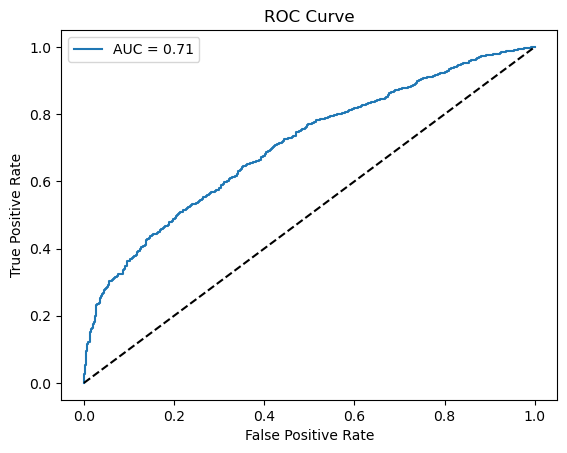

In [20]:
# 10. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

